Preprocessing

In [4]:
import os
import librosa
import math
import json

CURRENT_DIR = os.path.abspath(os.getcwd())
DATASET_PATH = os.path.join(os.path.join(CURRENT_DIR, "Data"), "genres_original")
JSON_PATH = os.path.join(os.path.join(CURRENT_DIR, "JSON"), "data.json")

SAMPLE_RATE = 22050
DURATION = 30 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    # dictionary to store data
    data = {
        "mapping":[],
        "mfcc":[],
        "labels":[]
    }

    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    # loop through all the genres

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensure that we're not at the root level
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_components = dirpath.split("\\")
            semantic_label = dirpath_components[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing {}".format(semantic_label))

            # process files for a specific genre
            for file in filenames:
                # load audio file
                file_path = os.path.join(dirpath, file)
                try:
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                    # process segments extracting mfcc and storing data
                    for s in range(num_segments):
                        start_sample = num_samples_per_segment * s
                        finish_sample = start_sample + num_samples_per_segment

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                sr=sr,
                                                n_fft = n_fft,
                                                n_mfcc=n_mfcc,
                                                hop_length=hop_length)

                        mfcc = mfcc.T

                        # store mfcc for segment if it has the expected length
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, s))

                except Exception as ex:
                    print("An error occurred")
                    pass

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing blues
C:\Users\chiar\Desktop\FDSProject\Data\genres_original\blues\blues.00000.wav, segment:0
C:\Users\chiar\Desktop\FDSProject\Data\genres_original\blues\blues.00000.wav, segment:1
C:\Users\chiar\Desktop\FDSProject\Data\genres_original\blues\blues.00000.wav, segment:2
C:\Users\chiar\Desktop\FDSProject\Data\genres_original\blues\blues.00000.wav, segment:3
C:\Users\chiar\Desktop\FDSProject\Data\genres_original\blues\blues.00000.wav, segment:4
C:\Users\chiar\Desktop\FDSProject\Data\genres_original\blues\blues.00000.wav, segment:5
C:\Users\chiar\Desktop\FDSProject\Data\genres_original\blues\blues.00000.wav, segment:6
C:\Users\chiar\Desktop\FDSProject\Data\genres_original\blues\blues.00000.wav, segment:7
C:\Users\chiar\Desktop\FDSProject\Data\genres_original\blues\blues.00000.wav, segment:8
C:\Users\chiar\Desktop\FDSProject\Data\genres_original\blues\blues.00000.wav, segment:9
C:\Users\chiar\Desktop\FDSProject\Data\genres_original\blues\blues.00001.wav, segment:0
C:\Users\chiar

Implementing a Neural Network for Genre Classification

In [6]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras


# load data
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)

    # convert lists into numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets



def split_train_test(inputs, targets):
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,
                                                                              targets,
                                                                              test_size=0.3)
    return inputs_train, inputs_test, targets_train, targets_test


def multilayer_perceptron_network(inputs, targets):
    inputs_train, inputs_test, targets_train, targets_test = split_train_test(inputs, targets)
    model = keras.Sequential([
        # input layer
        keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),
        # 1st hidden layer
        keras.layers.Dense(512, activation="relu"),
        # 2nd hidden layer
        keras.layers.Dense(256, activation="relu"),
        #3rd hidden layer
        keras.layers.Dense(64, activation="relu"),
        #output layer
        keras.layers.Dense(10, activation="softmax")
    ])

    # compile network
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer= optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    model.summary()

    # train multilayer_perceptron_network
    history = model.fit(inputs_train, targets_train,
              validation_data=(inputs_test, targets_test),
              epochs=100,
              batch_size=32)
    return history




In [7]:
CURRENT_DIR = os.path.abspath(os.getcwd())
JSON_PATH = os.path.join(os.path.join(CURRENT_DIR, "JSON"), "data.json")

inputs, targets = load_data(JSON_PATH)
history = multilayer_perceptron_network(inputs, targets)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               865792    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________
Train on 6990 samples, validate on 2996 samples
Epoch 1/100
6990/6990 [==============================] - 3s 38

6990/6990 [==============================] - 2s 309us/sample - loss: 0.2273 - accuracy: 0.9172 - val_loss: 2.4266 - val_accuracy: 0.5881
Epoch 49/100
6990/6990 [==============================] - 2s 332us/sample - loss: 0.1620 - accuracy: 0.9435 - val_loss: 2.6031 - val_accuracy: 0.5985
Epoch 50/100
6990/6990 [==============================] - 2s 349us/sample - loss: 0.2155 - accuracy: 0.9270 - val_loss: 2.5172 - val_accuracy: 0.5828
Epoch 51/100
6990/6990 [==============================] - 2s 329us/sample - loss: 0.2293 - accuracy: 0.9186 - val_loss: 2.5441 - val_accuracy: 0.5784
Epoch 52/100
6990/6990 [==============================] - 2s 328us/sample - loss: 0.2079 - accuracy: 0.9256 - val_loss: 2.5882 - val_accuracy: 0.5881
Epoch 53/100
6990/6990 [==============================] - 2s 344us/sample - loss: 0.1750 - accuracy: 0.9411 - val_loss: 2.5739 - val_accuracy: 0.5981
Epoch 54/100
6990/6990 [==============================] - 2s 321us/sample - loss: 0.1463 - accuracy: 0.9514 - val

Solving Overfitting for Multilayer Perceptron Network

In [8]:
import matplotlib.pyplot as plt

# plot accuracy and error over the epochs

def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="Train Accuracy")
    axs[0].plot(history.history["val_accuracy"], label="Test Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="Train Error")
    axs[1].plot(history.history["val_loss"], label="Test Error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Eval")

    plt.show()



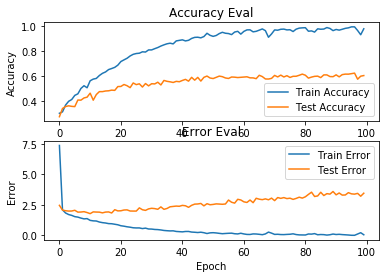

In [9]:
plot_history(history)

In [10]:
# re-defining the multilayer perceptron network
def optimized_MLP(inputs, targets):
    inputs_train, inputs_test, targets_train, targets_test = split_train_test(inputs, targets)
    model = keras.Sequential([
        # input layer
        keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),
        # 1st hidden layer
        keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),

        keras.layers.Dropout(0.3),

        # 2nd hidden layer
        keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),

        keras.layers.Dropout(0.3),

        #3rd hidden layer
        keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),

        keras.layers.Dropout(0.3),

        #output layer
        keras.layers.Dense(10, activation="softmax")
    ])

    # compile network
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer= optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    model.summary()

    # train multilayer_perceptron_network
    history = model.fit(inputs_train, targets_train,
              validation_data=(inputs_test, targets_test),
              epochs=100,
              batch_size=32)
    return history

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               865792    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

Epoch 46/100
6990/6990 [==============================] - 4s 523us/sample - loss: 2.2776 - accuracy: 0.4114 - val_loss: 2.3153 - val_accuracy: 0.4429
Epoch 47/100
6990/6990 [==============================] - 4s 560us/sample - loss: 2.2249 - accuracy: 0.4260 - val_loss: 2.3141 - val_accuracy: 0.4443
Epoch 48/100
6990/6990 [==============================] - 3s 489us/sample - loss: 2.1848 - accuracy: 0.4333 - val_loss: 2.2799 - val_accuracy: 0.4433
Epoch 49/100
6990/6990 [==============================] - 4s 515us/sample - loss: 2.1806 - accuracy: 0.4348 - val_loss: 2.2652 - val_accuracy: 0.4383
Epoch 50/100
6990/6990 [==============================] - 4s 505us/sample - loss: 2.1089 - accuracy: 0.4495 - val_loss: 2.2307 - val_accuracy: 0.4619
Epoch 51/100
6990/6990 [==============================] - 4s 513us/sample - loss: 2.1099 - accuracy: 0.4562 - val_loss: 2.1814 - val_accuracy: 0.4619
Epoch 52/100
6990/6990 [==============================] - 4s 517us/sample - loss: 2.0784 - accuracy:

6990/6990 [==============================] - 3s 490us/sample - loss: 1.1115 - accuracy: 0.7119 - val_loss: 1.9808 - val_accuracy: 0.5571


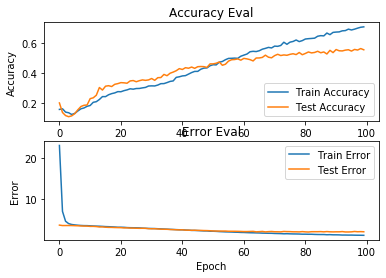

In [11]:
CURRENT_DIR = os.path.abspath(os.getcwd())
JSON_PATH = os.path.join(os.path.join(CURRENT_DIR, "JSON"), "data.json")


inputs, targets = load_data(JSON_PATH)
history = optimized_MLP(inputs, targets)
plot_history(history)

Convolutional Neural Network

In [12]:
# create train, validation and test sets
def prepare_datasets(test_size, validation_size, dataset_path):
    # load data
    X, y = load_data(dataset_path)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # creation of 4d arrays
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


# build the CNN network
def build_CNN(input_shape):
    # create model
    model = keras.Sequential()
    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten the output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

# prediction of a single sample
def predict(model, X, y):
    X = X[np.newaxis, ...]
    prediction = model.predict(X)

    # extracted index with max value
    predicted_index = np.argmax(prediction, axis=1)
    return predicted_index


def convolutional_neural_network(dataset_path):
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2, dataset_path)

    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    model = build_CNN(input_shape)

    # compile the network
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    model.summary()
    
    # train CNN
    history = model.fit(X_train, y_train, validation_data= (X_validation, y_validation), batch_size=32, epochs=30)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

    x_sample = X_test[100]
    y_sample = y_test[100]

    predicted_index = predict(model, x_sample, y_sample)
    prediction = (predicted_index, y_sample)

    return history, test_loss, test_accuracy, prediction

In [13]:
CURRENT_DIR = os.path.abspath(os.getcwd())
JSON_PATH = os.path.join(os.path.join(CURRENT_DIR, "JSON"), "data.json")
history, test_loss, test_accuracy, prediction = convolutional_neural_network(JSON_PATH)

print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))
print("Expected index: {}, Predicted index: {}".format(prediction[1], prediction[0]))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 1, 32)        

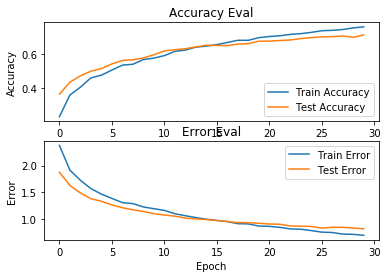

In [14]:
plot_history(history)


Recurrent Neural Network

In [ ]:
# create train, validation and test sets
def prepare_datasets(test_size, validation_size, dataset_path):
    # load data
    X, y = load_data(dataset_path)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


# build the RNN network
def build_RNN(input_shape):
    # create model
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))
    
    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def recurrent_neural_network(dataset_path):
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2, dataset_path)

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_RNN(input_shape)

    # compile the network
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    model.summary()
    
    # train CNN
    history = model.fit(X_train, y_train, validation_data= (X_validation, y_validation), batch_size=32, epochs=30)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    return history, test_loss, test_accuracy

In [ ]:
CURRENT_DIR = os.path.abspath(os.getcwd())
JSON_PATH = os.path.join(os.path.join(CURRENT_DIR, "JSON"), "data.json")
history, test_loss, test_accuracy = recurrent_neural_network(JSON_PATH)

print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))

In [ ]:
plot_history(history)

In [18]:
CURRENT_DIR = os.path.abspath(os.getcwd())
JSON_PATH = os.path.join(os.path.join(CURRENT_DIR, "JSON"), "data.json")
history, test_loss, test_accuracy = recurrent_neural_network(JSON_PATH)

print("Accuracy on test set is: {}".format(test_accuracy))
print("Loss on test set is: {}".format(test_loss))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 130, 64)           19968     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________
Train on 5991 samples, validate on 1498 samples
Epoch 1/30
5991/5991 [==============================] - 29s 5ms/samp

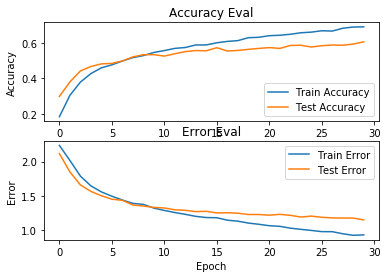

In [19]:
plot_history(history)